# This is primarly a project to read Raspberry seismic records installed in multiple locations around a quarry to record the quarry blast and measure the effect. 
## Feel free to improve the work. 

In [7]:
from obspy import read_inventory, read
from obspy.clients.fdsn import Client
from obspy.clients.iris import Client as Client1
from obspy.core import UTCDateTime, Stream
import matplotlib.pyplot as plt
import multiprocessing
import os
from matplotlib import transforms
import numpy as np
import pyrotd
import pandas as pd
from math import log10
from obspy.geodetics import gps2dist_azimuth
import seaborn as sns
   
pyrotd.processes = 10
osc_damping = 0.05
osc_freqs = np.logspace(-1, 2, 100)
inch=39.37
exp_lat= 29.5615
exp_lon=-98.6932

## Set the raspberry-seismic name and download the seismic record and instrument response file
#the csv file with the start time and end time for each records based on the quarry blastting , 
#please download the file and use it with read_csv 

In [7]:
stn = 'RA533'   # your station name
inv = read_inventory('https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?network=AM&station=%s&level=resp&format=xml' % (stn))
locs=pd.read_csv('D:\\blast_blake\\Data_blasts\\Events_data_final.csv',header=0,index_col=False)
event_num=locs.shape[0]                 

21

In [8]:
# set the FDSN server location and channel names
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')
channels = [ 'EHE', 'EHN', 'EHZ'] # ENx = accelerometer channels; EHx or SHZ = geophone channels



## Seismic Response Spectrum Functions

In [93]:
def stream_ch(stn,channels,start,end):
    stream= Stream()
    for ch in channels:
        trace = rs.get_waveforms('AM', stn, '00', ch, start, end)
        stream += trace
    npts = stream[0].stats.npts
    samprate = stream[0].stats.sampling_rate
    time_step=1/samprate
    return stream,npts,samprate,time_step


def remove_instrument_response(stream,plot): ##plot=True or False
    stream.attach_response(inv)
    # remove the response and plot
    tr=stream.copy()
    ACC_ch= tr.remove_response(output='ACC',pre_filt=(0.99,1,20,25),plot=plot).normalize(10) #m/s^2 to g (div 10)
    
    tr2=stream.copy()
    VEL_ch= tr2.remove_response(output='VEL',pre_filt=(0.99,1,20,25),plot=plot)  #m/s )
    
    tr1=stream.copy()
    DISP_ch= tr1.remove_response(output='DISP',pre_filt=(0.99,1,20,25),plot=plot)  #m)
   
    return ACC_ch,VEL_ch,DISP_ch

def rotate_RT(ACC_ch,Vel_ch,Disp_ch,stalat,stalon,evtlat,evtlon):
      
    client = Client1()
    result = client.distaz(stalat=stalat, stalon=stalon, evtlat=evtlat,evtlon=evtlon)
    ACC_ch1=ACC_ch.copy()
    ACC_ch_Rt=ACC_ch1.rotate(method="NE->RT", inventory=inv,back_azimuth=result['backazimuth']).detrend()
    
    Vel_ch1=Vel_ch.copy()
    Vel_ch_Rt=Vel_ch1.rotate(method="NE->RT", inventory=inv,back_azimuth=result['backazimuth']).detrend()
    
    Disp_ch1=Disp_ch.copy()
    Disp_ch_Rt=Disp_ch1.rotate(method="NE->RT", inventory=inv,back_azimuth=result['backazimuth']).detrend()
    return ACC_ch_Rt,Vel_ch_Rt,Disp_ch_Rt


def response_spectra(timestep,resp_removed_ACC_data,resp_removed_VEL_data, resp_removed_DISP_data, osc_freqs,osc_damping):
    resp_spec_ACC = pyrotd.calc_spec_accels(time_step, resp_removed_ACC_data.data, osc_freqs, osc_damping)
  
 
    
# Compute the velocity response spectrum
    resp_spec_VEL = pyrotd.calc_spec_accels(time_step, resp_removed_VEL_data.data, osc_freqs, osc_damping)
# Compute the Displacenent response spectr
    resp_spec_DISP = pyrotd.calc_spec_accels(time_step, resp_removed_DISP_data.data, osc_freqs, osc_damping)    
    return resp_spec_ACC ,  resp_spec_VEL , resp_spec_DISP

def plt_resposne_spectra(fig,axes,resp_spec_ACC,resp_spec_VEL,resp_spec_DISP,title): ## m/s to inch/s
    
    #fig, axes = plt.subplots(ncols=2,figsize=(8, 4),subplot_kw={'xscale':'log'},sharey=False, sharex=True)

    for ax, yscale in zip(axes, ['log', 'linear']):
        #ACC=ax.plot(resp_spec_ACC.osc_freq, resp_spec_ACC.spec_accel,'r')
        VEL=ax.plot(resp_spec_VEL.osc_freq, resp_spec_VEL.spec_accel*inch,'b')
        DISP=ax.plot(resp_spec_DISP.osc_freq, resp_spec_DISP.spec_accel*inch,'g')    
        ax.set_yscale(yscale)
        ax.grid()
        plt.title(title)
    standard_limits=axes[0].plot([1,2.8,10,40,100],[0.2,0.5,0.5,2,2],'k--')
    standard_limits=axes[0].plot([1,4,12,30,100],[0.2,0.75,0.75,2,2],'g--')
    axes[0].set_ylabel('5%-Damped Spectral Velocity (inches/sec)')
    plt.setp(axes, xlabel='Frequency (Hz)')
    axes[0].legend( ( 'VEL(inch/s)', 'DISP(inch)','STANDAARD'),loc='best')
       
    
    axes[0].set(xlim=(1, 100)) #,ylim=(0.04, 10)
    fig.tight_layout();
    
def plt_resposne_spectra_log(fig,ax,resp_spec_ACC,resp_spec_VEL,resp_spec_DISP,title,coloridx): ## m/s to inch/s
    
    standard_limits=ax.plot([1,2.8,10,40,100],[0.2,0.5,0.5,2,2],'k--', label='Standrad')
    standard_limits=ax.plot([1,4,12,30,100],[0.2,0.75,0.75,2,2],'g--')
    
    VEL=ax.plot(resp_spec_VEL.osc_freq, resp_spec_VEL.spec_accel*inch, color=plt.cm.tab20c(coloridx), lw=1,label="event{}".format(coloridx))
           
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()
    ax.set_title(title,fontsize=22)
    ax.set_ylabel('5%-Damped Spectral Velocity (inches/sec)',fontsize=10)
    ax.set_xlabel('Frequency (Hz)',fontsize=18)
    #ax.legend( ( 'VEL(inch/s)','Standard'),loc='best',fontsize=12) 
    #ax.legend(loc='best',fontsize=12) 
    ax.set(xlim=(1, 100)) #,ylim=(0.04, 10)
    fig.tight_layout()
    return VEL
def output_csv_response_spectra(resp_spec_ACC,resp_spec_VEL,resp_spec_DISP,comp,i): #i is events 
       
        #ACC in g
        if (comp==0):
            
            max_ACC=resp_spec_ACC.spec_accel.max()
            ind_ACC=np.argmax(resp_spec_ACC.spec_accel)
            ff0_ACC=resp_spec_ACC.osc_freq[ind_ACC]
            df_t.loc[i,'max_ACC']=max_ACC
            df_t.loc[i,'f0_ACC']=ff0_ACC
            #
            max_VEL=resp_spec_VEL.spec_accel.max()
            ind_VEL=np.argmax(resp_spec_VEL.spec_accel)
            ff0_VEL=resp_spec_VEL.osc_freq[ind_VEL]
            df_t.loc[i,'max_VEL']=max_VEL*inch
            df_t.loc[i,'f0_VEL']=ff0_VEL
            #
            max_DISP=resp_spec_DISP.spec_accel.max()
            ind_DISP=np.argmax(resp_spec_DISP.spec_accel)
            ff0_DISP=resp_spec_DISP.osc_freq[ind_DISP]
            df_t.loc[i,'max_DISP']=max_DISP*inch
            df_t.loc[i,'f0_DISP']=ff0_DISP
        elif (comp==1):
            max_ACC=resp_spec_ACC.spec_accel.max()
            ind_ACC=np.argmax(resp_spec_ACC.spec_accel)
            ff0_ACC=resp_spec_ACC.osc_freq[ind_ACC]
            df_r.loc[i,'max_ACC']=max_ACC
            df_r.loc[i,'f0_ACC']=ff0_ACC
            #
            max_VEL=resp_spec_VEL.spec_accel.max()
            ind_VEL=np.argmax(resp_spec_VEL.spec_accel)
            ff0_VEL=resp_spec_VEL.osc_freq[ind_VEL]
            df_r.loc[i,'max_VEL']=max_VEL*inch
            df_r.loc[i,'f0_VEL']=ff0_VEL
            #
            max_DISP=resp_spec_DISP.spec_accel.max()
            ind_DISP=np.argmax(resp_spec_DISP.spec_accel)
            ff0_DISP=resp_spec_DISP.osc_freq[ind_DISP]
            df_r.loc[i,'max_DISP']=max_DISP*inch
            df_r.loc[i,'f0_DISP']=ff0_DISP
            
        elif (comp==2):
            
            max_ACC=resp_spec_ACC.spec_accel.max()
            ind_ACC=np.argmax(resp_spec_ACC.spec_accel)
            ff0_ACC=resp_spec_ACC.osc_freq[ind_ACC]
            df_z.loc[i,'max_ACC']=max_ACC
            df_z.loc[i,'f0_ACC']=ff0_ACC
            #
            max_VEL=resp_spec_VEL.spec_accel.max()
            ind_VEL=np.argmax(resp_spec_VEL.spec_accel)
            ff0_VEL=resp_spec_VEL.osc_freq[ind_VEL]
            df_z.loc[i,'max_VEL']=max_VEL*inch
            df_z.loc[i,'f0_VEL']=ff0_VEL
            #
            max_DISP=resp_spec_DISP.spec_accel.max()
            ind_DISP=np.argmax(resp_spec_DISP.spec_accel)
            ff0_DISP=resp_spec_DISP.osc_freq[ind_DISP]
            df_z.loc[i,'max_DISP']=max_DISP*inch
            df_z.loc[i,'f0_DISP']=ff0_DISP
        return comp

def magnitude_local(st,sta_lat, sta_lon,event_lat, event_lon):
    paz_wa = {'sensitivity': 2800, 'zeros': [0j],'gain': 1,'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}
    st.simulate(paz_remove=None, paz_simulate=paz_wa, water_level=10)
    tr_n = st.select(channel="EHN")[0]
    ampl_n = max(abs(tr_n.data))

    tr_e = st.select(channel="EHE")[0]
    ampl_e = max(abs(tr_e.data))

    ampl = max(ampl_n, ampl_e)

    epi_dist, az, baz = gps2dist_azimuth(event_lat, event_lon, sta_lat, sta_lon)
    EpiDist = epi_dist / 1000
    
    if EpiDist < 60:
        a = 0.018
        b = 2.17
        ml = log10(ampl * 1000) + (a * EpiDist) + b       
    else:
        a = 0.0038
        b = 3.02
        ml = log10(ampl * 1000) + (a * EpiDist) + b
   
    return EpiDist, ml
    
def plt_scatter_text(data,x, y, text_column):
     # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
     
    return p1



In [81]:

strm=[]
for i in range(0,event_num,1):
    start = UTCDateTime(locs.date[i]+locs.time_start_UTC[i])
    end = UTCDateTime(locs.date[i]+locs.time_end_UTC[i])
    stream,npts,samrate,time_step=stream_ch(stn,channels,start,end)
    strm.append(stream)
    #print('#event=',i) #check the event


#event= 0
#event= 1
#event= 2
#event= 3
#event= 4
#event= 5
#event= 6
#event= 7
#event= 8
#event= 9
#event= 10
#event= 11
#event= 12
#event= 13
#event= 14
#event= 15
#event= 16
#event= 17
#event= 18
#event= 19
#event= 20


Exp 20 the distance and the magnitude: 2.2074059476540735 2.0550585469759435


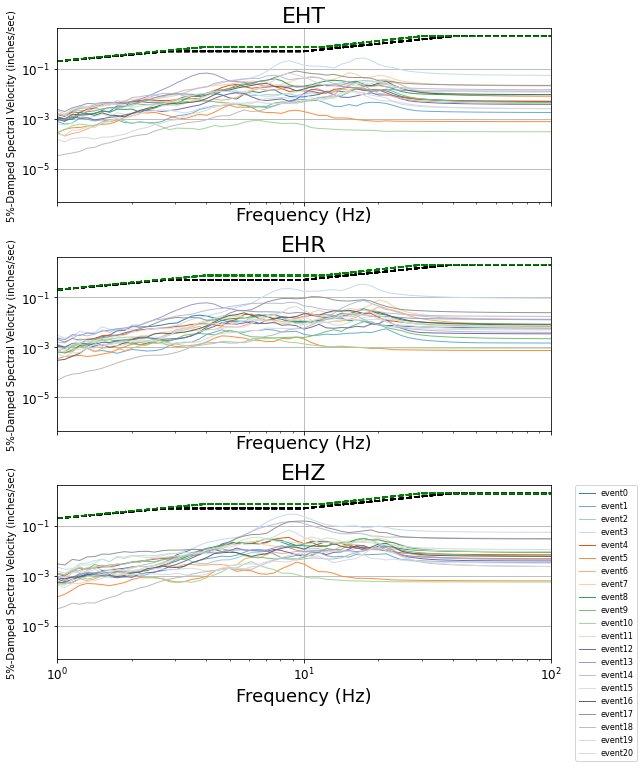

In [94]:
#Fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12, 10),subplot_kw={'xscale':'log'},sharey=False, sharex=True)

columns= ['max_ACC','f0_ACC','max_VEL','f0_VEL','max_DISP','f0_DISP']
df_t = pd.DataFrame( columns=columns)
df_r = pd.DataFrame( columns=columns)
df_z = pd.DataFrame( columns=columns)
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(8,10 ),subplot_kw={'xscale':'log','yscale':'log'},sharey=True, sharex=True)##all lines in one plot
lines=[]
for j in range(0,event_num,1): # how many streams (events)
    #fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12, 10),subplot_kw={'xscale':'log'},sharey=False, sharex=True) #each event in one page
    ACC_ch,Vel_ch,Disp_ch =remove_instrument_response(strm[j],False)
    ACCinp,VELinp, DISPinp =rotate_RT(ACC_ch,Vel_ch,Disp_ch,locs.loc[j].lat,locs.loc[j].lon,exp_lat,exp_lon)
    dists,mags=magnitude_local(Disp_ch,locs.loc[j].lat,locs.loc[j].lon,exp_lat,exp_lon) 
    locs.loc[j,'mag']=mags
    locs.loc[j,'epidist']=dists
   
    for i in range(0,3,1):## cmponents x,y,z or T, R ,Z
        resp_spec_ACC , resp_spec_VEL,resp_spec_DISP= response_spectra(time_step,ACCinp[i],VELinp[i],DISPinp[i],osc_freqs, osc_damping)
        #
        output_csv_response_spectra(resp_spec_ACC,resp_spec_VEL,resp_spec_DISP,i,j)
        lab=plt_resposne_spectra_log(fig,axes[i],resp_spec_ACC,resp_spec_VEL,resp_spec_DISP,DISPinp[i].stats.channel,j)
    lines+=lab   
        #fig.savefig('oneplot'+str(j)+'.png')
labels = [l.get_label() for l in lines]
plt.legend(lines, labels,fontsize=8,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)       
fig.savefig('allplots.png')
print('Exp',j,'the distance and the magnitude:',dists, mags)

In [105]:
df_t.to_csv('D:\\blast_blake\\Data_blasts\\response_spectra_t')
df_r.to_csv('D:\\blast_blake\\Data_blasts\\response_spectra_r')
df_z.to_csv('D:\\blast_blake\\Data_blasts\\response_spectra_z')

In [ ]:
#df_z.head

# Another way to plot the results

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12, 10),subplot_kw={'xscale':'log','yscale':'log'},sharey=False, sharex=True)
axes[0].plot(df_t.f0_ACC,df_t.max_ACC,'ko');
axes[1].plot(df_t.f0_VEL,df_t.max_VEL,'ko');
axes[2].plot(df_t.f0_DISP,df_t.max_DISP,'ko');
#
axes[0].plot(df_r.f0_ACC,df_r.max_ACC,'bo');
axes[1].plot(df_r.f0_VEL,df_r.max_VEL,'bo');
axes[2].plot(df_r.f0_DISP,df_r.max_DISP,'bo');
#
axes[0].plot(df_z.f0_ACC,df_z.max_ACC,'ro');
axes[1].plot(df_z.f0_VEL,df_z.max_VEL,'ro');
axes[2].plot(df_z.f0_DISP,df_z.max_DISP,'ro');
#
standard_limits=axes[1].plot([1,2.8,10,40,100],[0.2,0.5,0.5,2,2],'k--')
standard_limits=axes[1].plot([1,4,12,30,100],[0.2,0.75,0.75,2,2],'g--')
fig.savefig('seis_resp.png')

# Save to CSV

In [34]:
locs.to_csv('D:\\blast_blake\\Data_blasts\\blast_locs.csv')

# Plot maps

## Plot folium map for the target query with the locations where the instrument were installed.  

In [35]:
import geopandas as gpd
import pyproj 

In [36]:
# Read in the data
#full_data = gpd.read_file("../input/geospatial-learn-course-data/DEC_lands/DEC_lands/DEC_lands.shp")
#geology_TX = gpd.read_file('./data/raw/Geology/WIgeol_dd/wigeol_poly_dd.shp')
#projection
#use pyproj to transform it to both latlong (WGS84) and UTM zone 16 (WGS84).
# North American Datum 1927
p1 = pyproj.Proj(proj='latlong', datum='NAD27')
# WGS84 Latlong
p2 = pyproj.Proj(proj='latlong', datum='WGS84')
# WGS84 UTM Zone 16
p3 = pyproj.Proj(proj='utm', zone=16, datum='WGS84')

In [38]:
from shapely import geometry
import folium
data=locs.groupby('name').mean()
mag_data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))
#mag_data.to_csv('./data/processed/mag.csv')
#.envelope is a shapely method to get the bounding rectangle of all the points in the geometry.
multipoints = geometry.MultiPoint(mag_data['geometry'])
bounds = multipoints.envelope
#Let's save the bounds for the next parts of Integrating & Exploring.
gpd.GeoSeries(bounds).to_file('area_of_study_bounds.gpkg', 'GPKG')
#Let's get the coordinates of the .boundary of the bounds.
coords = np.vstack(bounds.boundary.coords.xy)
map_center = list(coords.mean(1))[::-1]
#
m = folium.Map(location=map_center, zoom_start=13, control_scale=True)
folium.PolyLine(coords[::-1].T).add_to(m)
folium.LatLngPopup().add_to(m)
#m

# plot stns

tooltip = 'Click me!'
folium.Marker([exp_lat, exp_lon], popup='<i>Quarry</i>',icon=folium.Icon(color='black'), tooltip=tooltip).add_to(m)
#seism_loc = folium.map.FeatureGroup()
latitudes = list(mag_data.lat)
longitudes = list(mag_data.lon)
labels = list(mag_data.index)
for i in range(0,len(mag_data),1):
    folium.Marker(
    location =[latitudes[i],longitudes[i]] , 
    popup = labels[i],
    #icon = folium.Icon(color='blue')
    icon=folium.DivIcon(html=f"""<div style="color:{'red'};">{labels[i]}</div>""")
    ).add_to(m) 
   # m.add_child(seism_loc)
#fg = folium.FeatureGroup(name='data').add_to(m)

folium.LayerControl().add_to(m)
m

# Plot a recorded location map with magnitude values
##I used two shapefiles; Geology units and faults. Please download and modify the path in the following steps:


C:\Users\ryass\anaconda3\envs\obspy\lib\site-packages\geopandas\plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


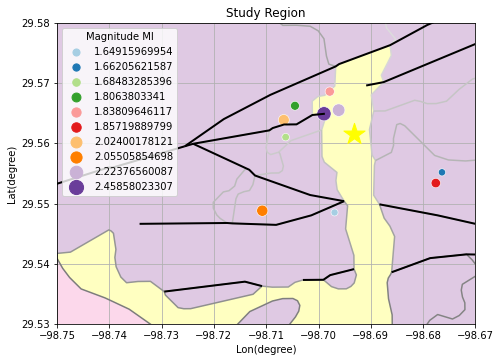

In [39]:
#bounding box
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,figsize=(7.5, 6))



qloc=pd.DataFrame({'num':1,'exp_lon':exp_lon, 'exp_lat':exp_lat},index=['0'])
gqloc=gpd.GeoDataFrame(qloc,geometry=gpd.points_from_xy(qloc.exp_lon, qloc.exp_lat), crs="EPSG:4326")
        
bbox=[-98.8,29.4,-98.6,29.7 ] 
xmin=-98.75;xmax=-98.67;ymin=29.53;ymax=29.58
#quarry location
#mag=gpd.GeoDataFrame(groups, geometry=gpd.points_from_xy(groups.lon, groups.lat), crs="EPSG:4326")
mag=gpd.GeoDataFrame(mag_data, geometry=gpd.points_from_xy(mag_data.lon, mag_data.lat), crs="EPSG:4326")
#magplt=mag.plot(ax=ax,column='mag',marker='o', markersize=15,zorder=2,legend=True,legend_kwds={'label': "Blast Local Magnitude/Ml",
#                                                                   ...   'orientation': "horizontal"})
magplt=sns.scatterplot(zorder=4,ax=ax,data=mag,x="lon", y="lat", size='mag',hue='mag',sizes=(50, 200),
                       hue_norm=(0, 3), legend="full", palette="Paired",edgecolors='black')

gqplt=gqloc.plot(ax=ax,marker='*', markersize=500,color='yellow',zorder=3,legend=True)
geo_p=gpd.read_file('D:\\shapefile_repository\\TXgeol_dd\\TXgeol_dd_polygon.shp',bbox=bbox).to_crs("EPSG:4326") 
rockplt=geo_p.plot(ax=ax,column='ROCKTYPE1', cmap='Set1',zorder=1,legend=True,alpha=0.3)
geo_arc=gpd.read_file('D:\\shapefile_repository\\TXgeol_dd\\TXgeol_dd_arc.shp',bbox=bbox).to_crs("EPSG:4326")
geoplt=geo_arc.plot(ax=ax,cmap='Greys',zorder=2,legend=False)
fault=gpd.read_file('D:\\shapefile_repository\\TXfaults_dd\\TXfaults_dd.shp',bbox=bbox).to_crs("EPSG:4326") 
fplt=fault.plot(ax=ax,column='ARC_CODE',color='black',zorder=4,linewidths=2,linestyle='-',legend=True,legend_kwds={'label':"Fault"})
                                         
##
ax.grid()
ax.set_xlabel('Lon(degree)')
ax.set_ylabel('Lat(degree)')
ax.set_title('Study Region')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# adding legend handle
#from matplotlib.patches import Patch
#from matplotlib.lines import Line2D
#legend_elements = [Line2D([0], [0], color='k', lw=4, label='Fault'),
#                   Line2D([0], [0], marker='o', color='b', label='seismometer',
#                          markerfacecolor='b', markersize=15),
#                   Patch(facecolor='orange', edgecolor='r',
#                         label='Rock Type')]
#
#ax.legend(handles=legend_elements,bbox_to_anchor=(1.001, 1), loc='upper left', borderaxespad=0.)

l = plt.legend(loc='upper left',title='Magnitude Ml')
l.set_zorder(5) 
fig.savefig('Helots_blast.jpg',dpi=200)

# HVSR calculation for each record

In [109]:

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime, Stream
import hvsrpy
from hvsrpy import utils
from obspy.clients.fdsn import Client
import glob

In [110]:
locs=pd.read_csv('D:\\blast_blake\\Data_blasts\\Events_data_final.csv',header=0,index_col=False)
locs.head(20)
exp_lat= 29.5615
exp_lon=-98.6932
#NNNNOtce:run it only once
stn='RA533'
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')
channels = [ 'EHE', 'EHN', 'EHZ'] # ENx = accelerometer channels; EHx or SHZ = geophone channels

duration=4000

In [44]:
#Doanload data please DO NOT  Run it every time , it takes long time
for i in range(16,event_num,1):
    start = UTCDateTime(locs.date[i]+locs.time_start_UTC[i])
    name=locs.name[i]
    print (name)  
    trace1 = rs.get_waveforms('AM', stn, '00', channels[0], start, start+duration)
    trace2 = rs.get_waveforms('AM', stn, '00', channels[1], start, start+duration)
    trace3 = rs.get_waveforms('AM', stn, '00', channels[2], start, start+duration)
    stream= Stream()
    stream+=trace1
    stream+=trace2
    stream+=trace3
    if stream.count()==3: 
        mseed_file=stream.write('D:\\blast_blake\\Data_blasts\\' + stn + '_'  + name +'_' +
                            str(locs.date[i])+'_'+str(locs.time_start_UTC[i]).replace(':','-',3)+'.mseed' , format="MSEED")
    else:
        mseed_file=stream.merge(method=1,fill_value='interpolate', 
                                         interpolation_samples=0).write('D:\\blast_blake\\Data_blasts\\' + stn + '_'  + name +'_' +
                            str(locs.date[i])+'_'+str(locs.time_start_UTC[i]).replace(':','-',3)+'.mseed' , format="MSEED")
        
        print('meregedfile',str(i))
    
    

S8
S9
error 17
S9
error 18
S9
error 19
S11
error 20


# Calling the mseed files from the directory where we save them 
## change the directory to where you saved the mseed files


In [111]:
%cd D:\blast_blake\Data_blasts
mseed_list = [f for f in glob.glob("*.mseed")]
#mseed_list

D:\blast_blake\Data_blasts


['RA533_00_RC_2020-06-29_15-32-28.mseed',
 'RA533_01_RC_2020-06-30_15-37-28.mseed',
 'RA533_02_TH_2020-07-07_17-07-46.mseed',
 'RA533_03_TH_2020-07-10_16-30-56.mseed',
 'RA533_04_OH_2020-07-13_22-13-45.mseed',
 'RA533_05_OH_2020-07-14_16-21-20.mseed',
 'RA533_06_OH_2020-07-15_16-59-00.mseed',
 'RA533_07_AH_2020-07-23_14-54-50.mseed',
 'RA533_08_MH_2020-07-28_15-04-18.mseed',
 'RA533_09_MH_2020-07-29_16-37-22.mseed',
 'RA533_10_HH_2020-08-03_17-50-35.mseed',
 'RA533_11_HH_2020-08-04_15-11-00.mseed',
 'RA533_12_HH_2020-08-06_15-28-36.mseed',
 'RA533_13_HH_2020-08-07_14-59-02.mseed',
 'RA533_14_TH2_2020-08-11_15-46-34.mseed',
 'RA533_15_TH2_2020-08-12_15-30-14.mseed',
 'RA533_16_OH2_2020-09-24_17-05-08.mseed',
 'RA533_17_OH2_2020-09-25_15-43-14.mseed',
 'RA533_S11_2020-10-15_18-33-07.mseed',
 'RA533_S8_2020-09-25_15-43-14.mseed',
 'RA533_S9_2020-09-29_16-50-50.mseed',
 'RA533_S9_2020-10-02_17-38-50.mseed',
 'RA533_S9_2020-10-02_17-50-26.mseed']

## I adapted the hvsrpy code (credited to Joseph Vantassel)
#https://github.com/jpvantassel/hvsrpy or
#pypi.org/project/hvsrpy/

-----------------------


windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.87 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.46                           0.6
Fundamental Site Period, T0                 0.69                           0.6


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  9 of 50 allowed
No. of rejected windows                           24


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.10                          0.05
Fundamental Site Period, T0                 0.91                          0.05

#event: 0
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.44 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.92                          0.78
Fundamental Site Period, T0                 0.52                          0.78


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  9 of 50 allowed
No. of rejected windows                           26


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.15                          0.07
Fundamental Site Period, T0                 0.87                          0.07

#event: 1
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.50 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.85                          0.23
Fundamental Site Period, T0                 0.21                          0.23


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                            5


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.98                          0.12
Fundamental Site Period, T0                 0.20                          0.12

#event: 2
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.77 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.61                          0.26
Fundamental Site Period, T0                 0.22                          0.26


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            4


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.58                          0.15
Fundamental Site Period, T0                 0.22                          0.15

#event: 3
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.49 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.83                          0.55
Fundamental Site Period, T0                 0.35                          0.55


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.83                          0.55
Fundamental Site Period, T0                 0.35                          0.55

#event: 4
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.42 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              3.60                           0.5
Fundamental Site Period, T0                 0.28                           0.5


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  4 of 50 allowed
No. of rejected windows                           13


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.43                          0.12
Fundamental Site Period, T0                 0.23                          0.12

#event: 5
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.49 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              3.35                          0.42
Fundamental Site Period, T0                 0.30                          0.42


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                           15


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              3.79                          0.08
Fundamental Site Period, T0                 0.26                          0.08

#event: 6
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.39 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              7.88                          0.21
Fundamental Site Period, T0                 0.13                          0.21


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            2


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              8.02                          0.18
Fundamental Site Period, T0                 0.12                          0.18

#event: 7
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.52 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.65                          0.79
Fundamental Site Period, T0                 0.38                          0.79


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.65                          0.79
Fundamental Site Period, T0                 0.38                          0.79

#event: 8
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.42 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.66                          0.64
Fundamental Site Period, T0                 0.38                          0.64


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.66                          0.64
Fundamental Site Period, T0                 0.38                          0.64

#event: 9
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.66 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.59                          0.58
Fundamental Site Period, T0                 0.63                          0.58


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  7 of 50 allowed
No. of rejected windows                           22


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.15                          0.07
Fundamental Site Period, T0                 0.87                          0.07

#event: 10
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.47 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.75                          0.75
Fundamental Site Period, T0                 0.57                          0.75


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                           21


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.15                          0.07
Fundamental Site Period, T0                 0.87                          0.07

#event: 11
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.67 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.23                          0.89
Fundamental Site Period, T0                 0.45                          0.89


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.23                          0.89
Fundamental Site Period, T0                 0.45                          0.89

#event: 12
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.57 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.80                          0.79
Fundamental Site Period, T0                 0.56                          0.79


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              1.80                          0.79
Fundamental Site Period, T0                 0.56                          0.79

#event: 13
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.52 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.08                          0.22
Fundamental Site Period, T0                 0.24                          0.22


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  7 of 50 allowed
No. of rejected windows                           17


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.31                          0.03
Fundamental Site Period, T0                 0.23                          0.03

#event: 14
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.51 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.29                          0.06
Fundamental Site Period, T0                 0.23                          0.06


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                            9


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.26                          0.04
Fundamental Site Period, T0                 0.23                          0.04

#event: 15
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.36 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.18                          0.15
Fundamental Site Period, T0                 0.16                          0.15


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  6 of 50 allowed
No. of rejected windows                           15


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.60                          0.07
Fundamental Site Period, T0                 0.15                          0.07

#event: 16
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.34 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.38                          0.07
Fundamental Site Period, T0                 0.16                          0.07


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                           15


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.41                          0.03
Fundamental Site Period, T0                 0.16                          0.03

#event: 17
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.34 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              3.00                          0.59
Fundamental Site Period, T0                 0.33                          0.59


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              3.00                          0.59
Fundamental Site Period, T0                 0.33                          0.59

#event: 18
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.58 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.38                          0.07
Fundamental Site Period, T0                 0.16                          0.07


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  5 of 50 allowed
No. of rejected windows                           15


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              6.41                          0.03
Fundamental Site Period, T0                 0.16                          0.03

#event: 19


<ipython-input-112-2da9fe1de002>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,6), dpi=150)


windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.37 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.83                           0.6
Fundamental Site Period, T0                 0.35                           0.6


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  1 of 50 allowed
No. of rejected windows                            0


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              2.83                           0.6
Fundamental Site Period, T0                 0.35                           0.6

#event: 20
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.52 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.05                           0.6
Fundamental Site Period, T0                 0.25                           0.6


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                           12


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              5.23                          0.28
Fundamental Site Period, T0                 0.19                          0.28

#event: 21
windowlength: 60
width: 0.1
bandwidth: 40
resampling: {'minf': 1, 'maxf': 10, 'nf': 128, 'res_type': 'log'}
method: geometric-mean
Elapsed Time: 0.52 seconds

Statistics before rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              4.33                          0.62
Fundamental Site Period, T0                 0.23                          0.62


Analysis summary:


Window length                                    60s
No. of windows                                    66
Number of iterations to convergence  3 of 50 allowed
No. of rejected windows                           11


Statistics after rejection:


Lognormal Median  Lognormal Standard Deviation
Fundamental Site Frequency, f0              5.53                          0.31
Fundamental Site Period, T0                 0.18                          0.31

#event: 22


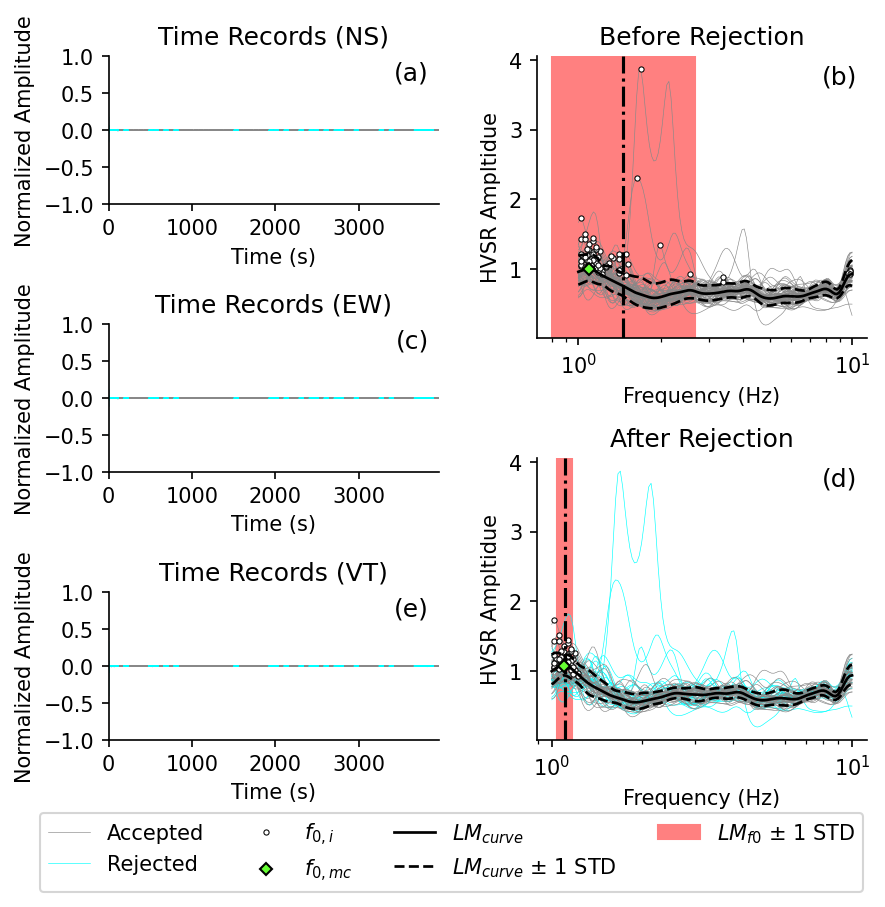

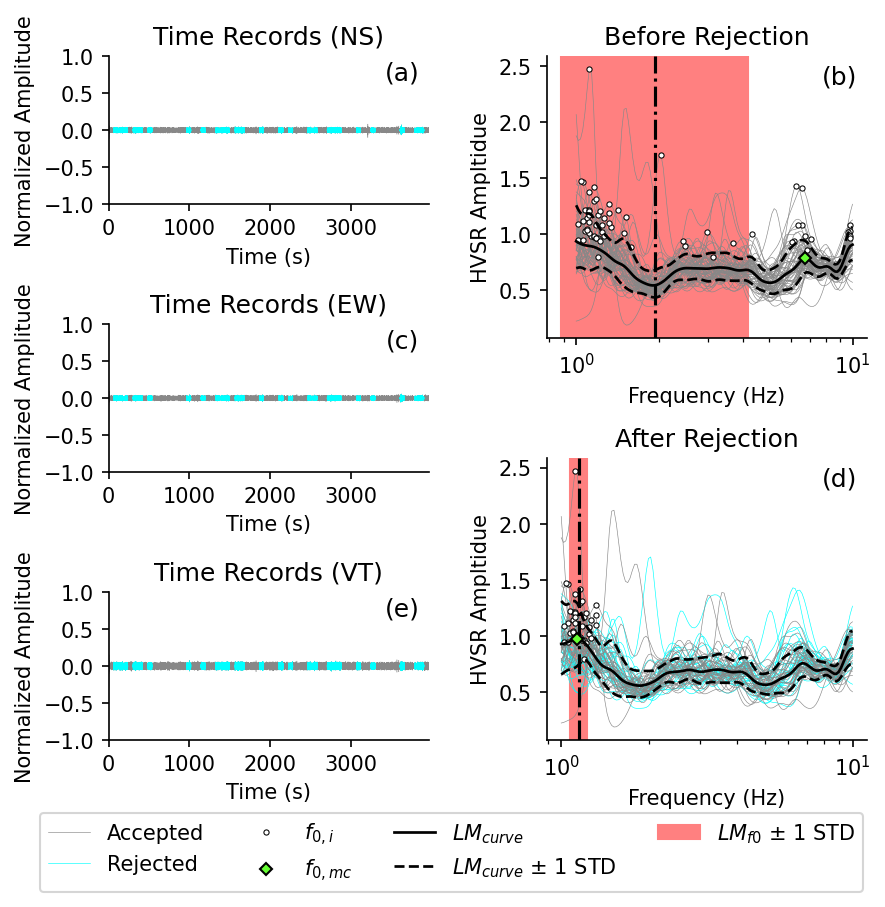

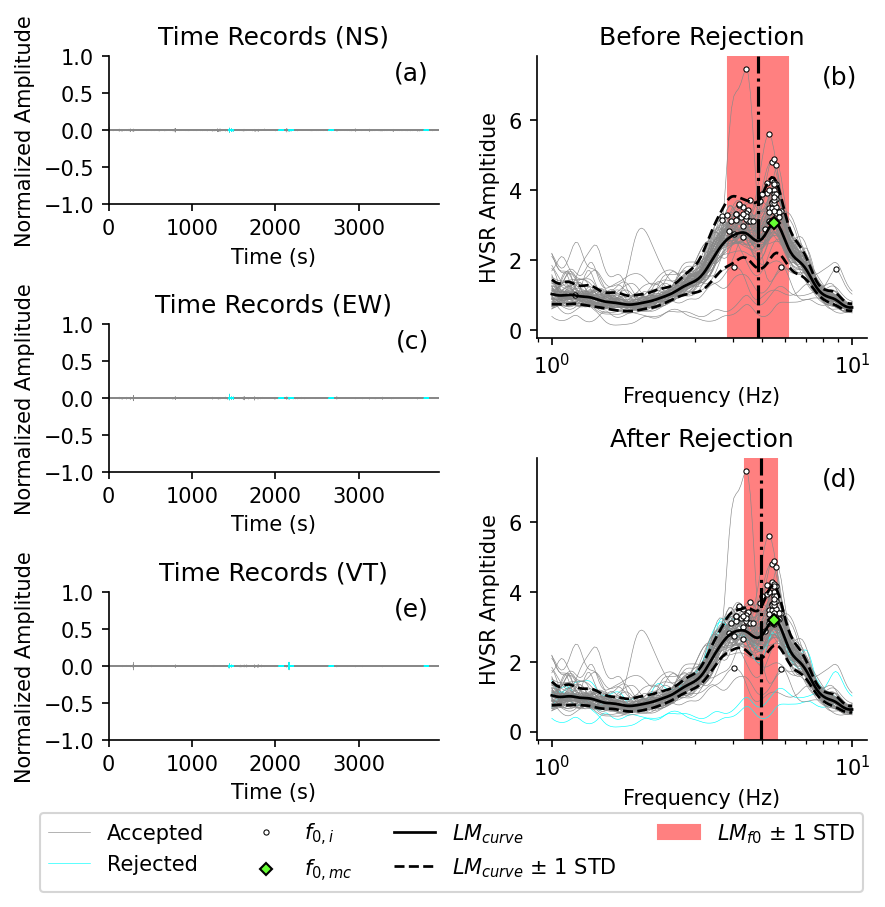

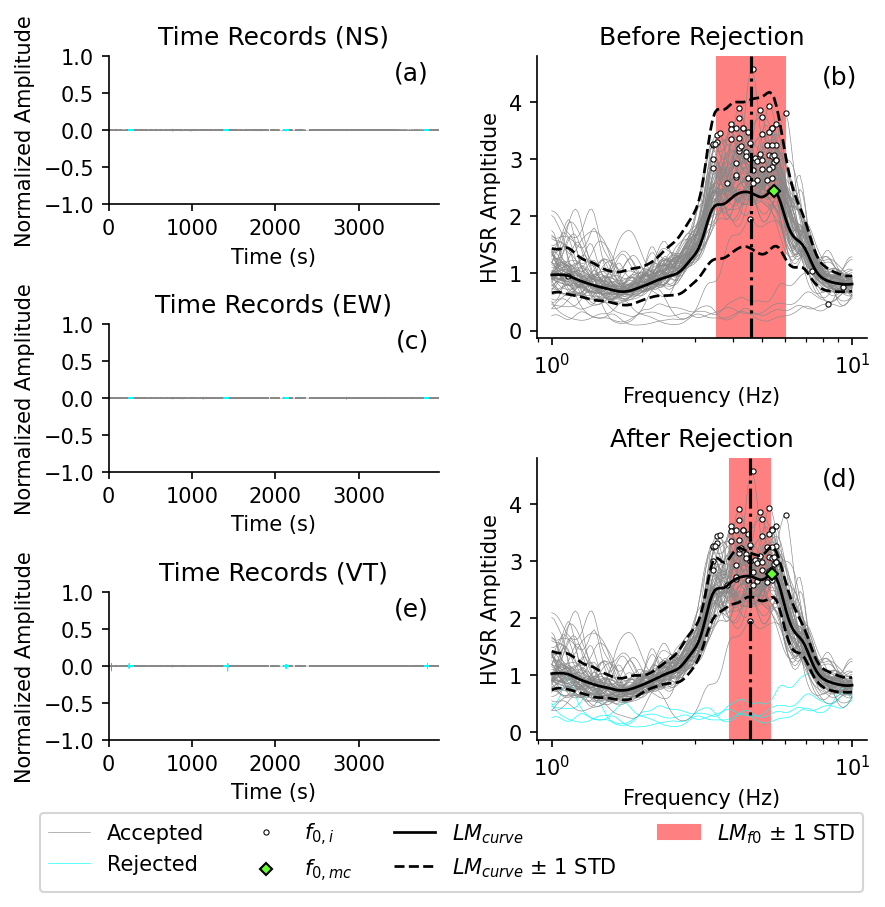

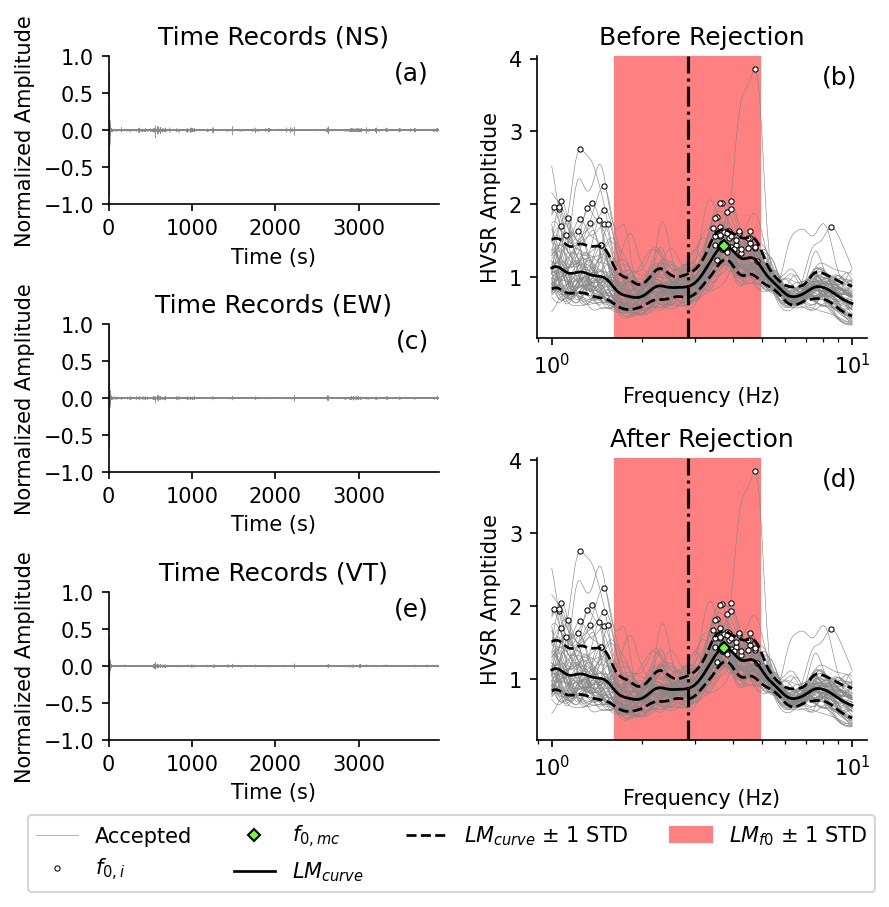

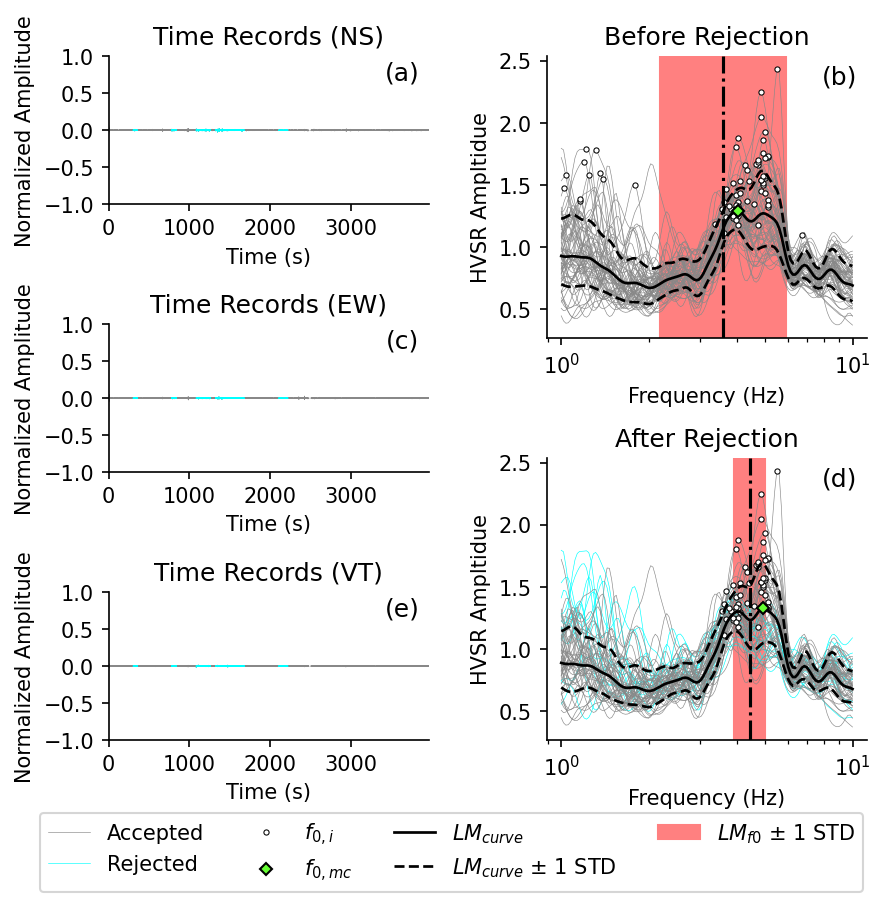

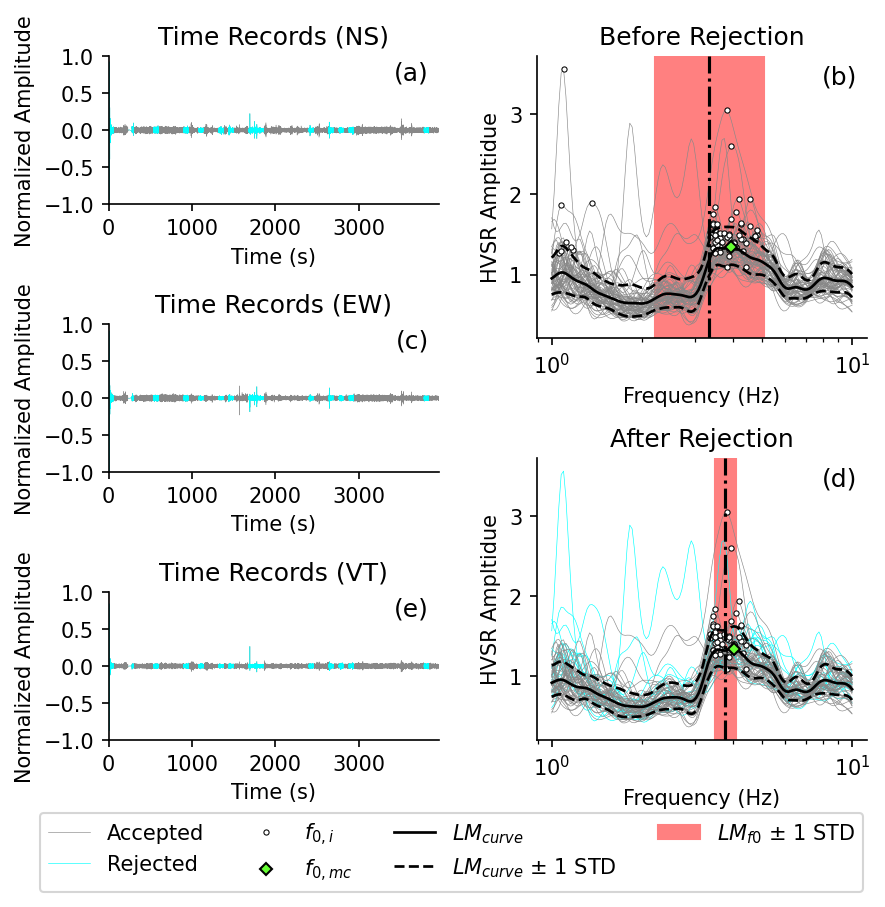

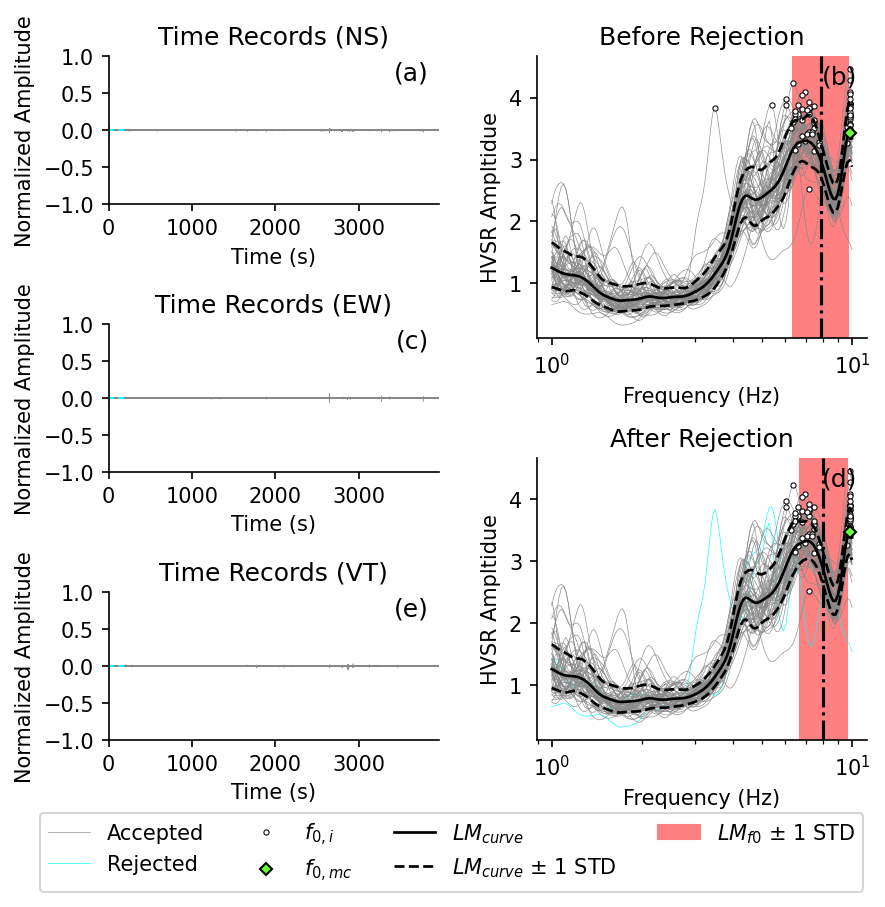

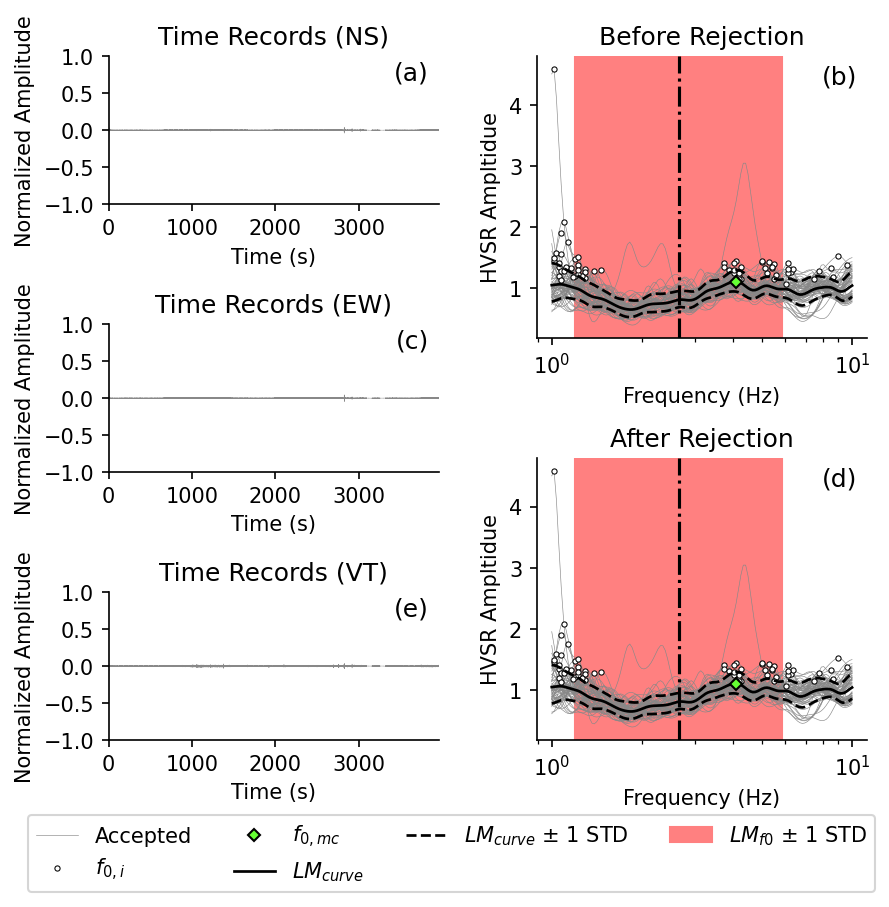

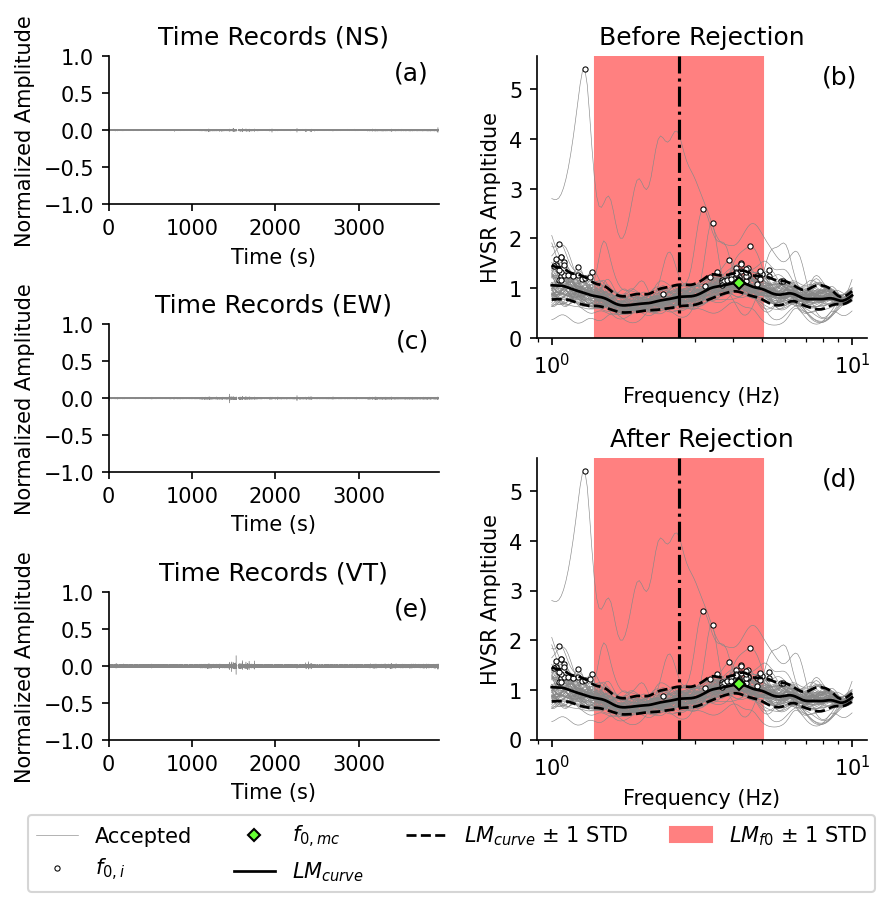

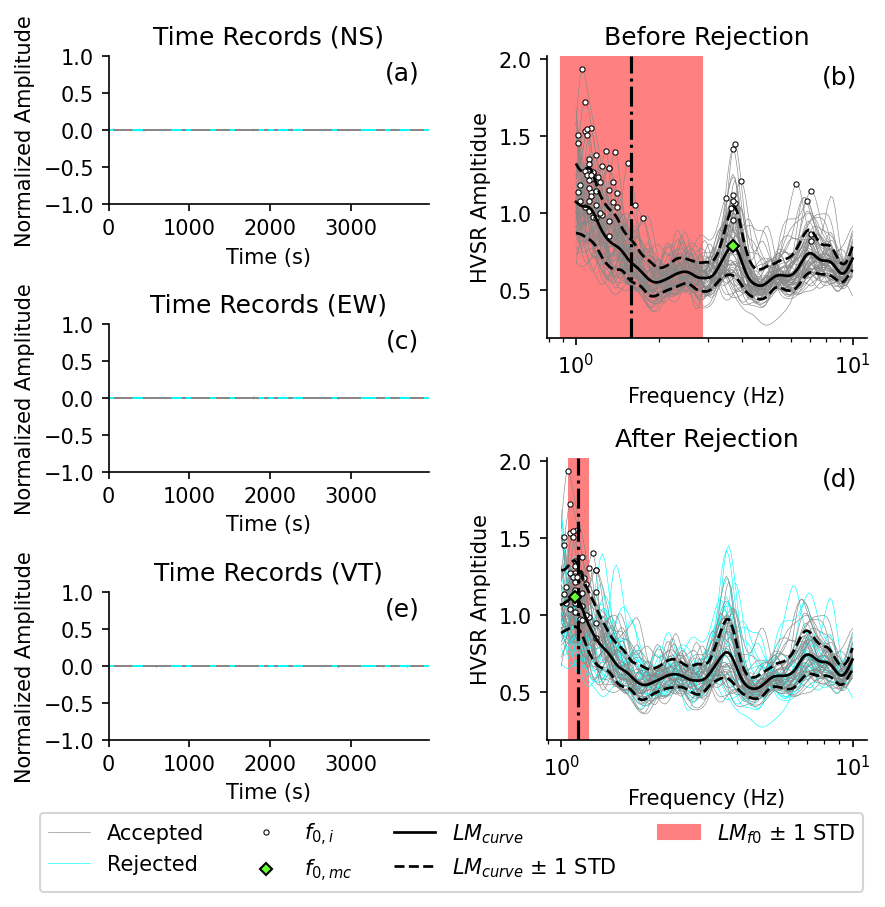

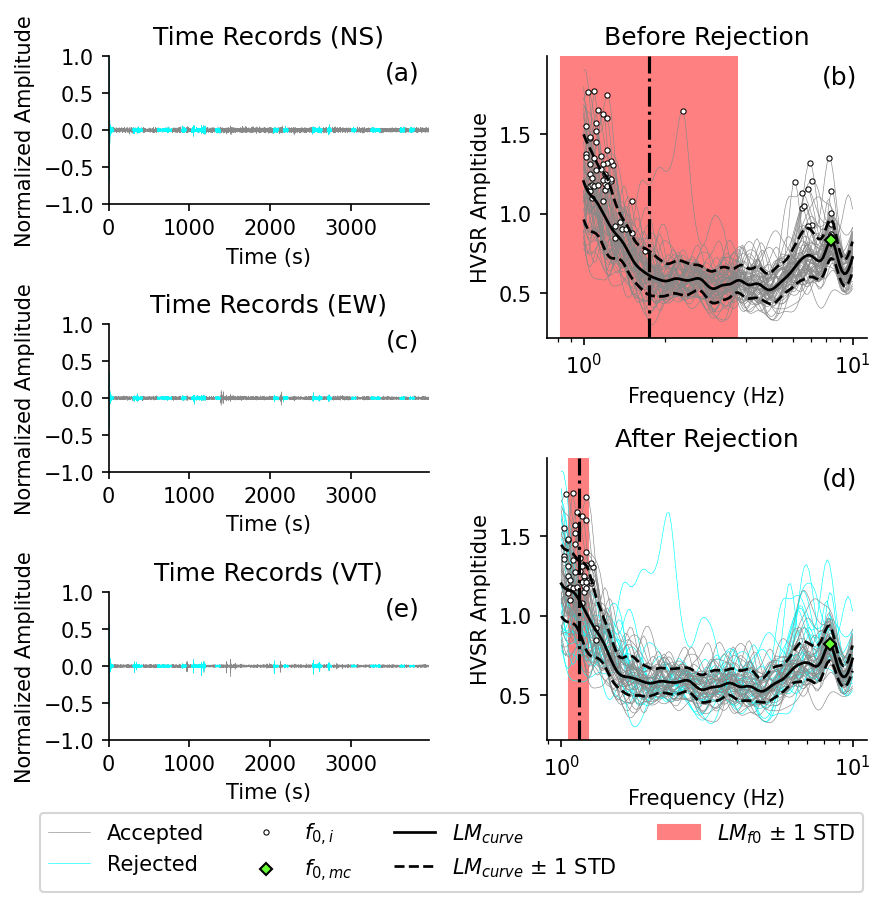

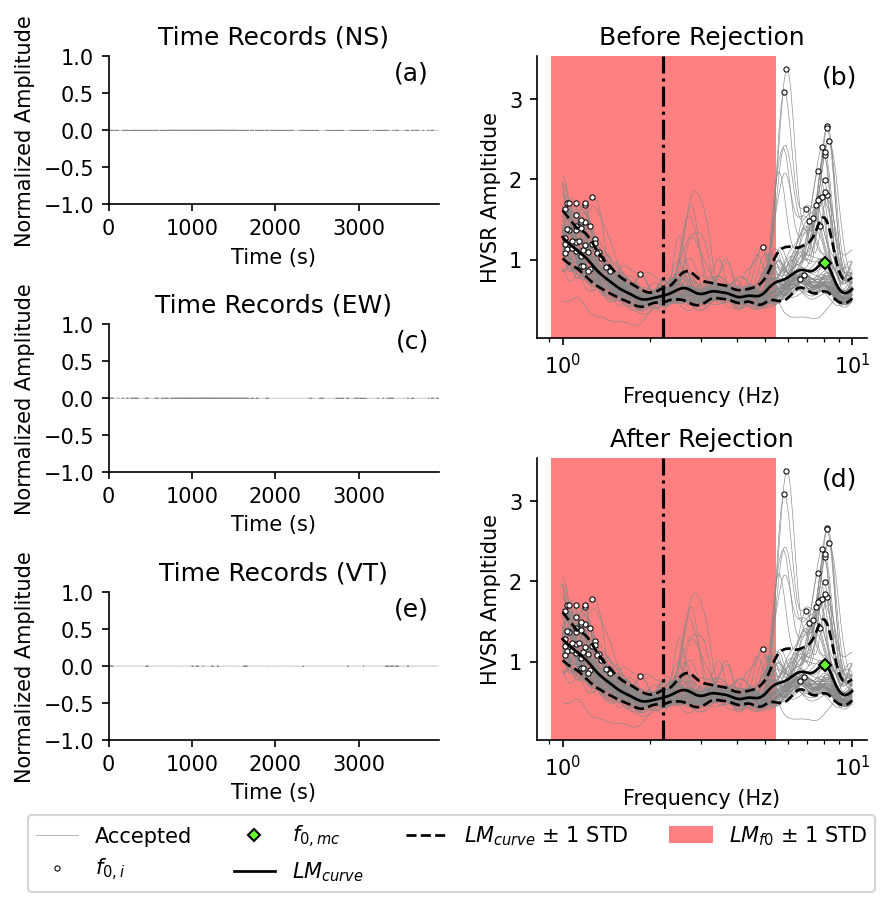

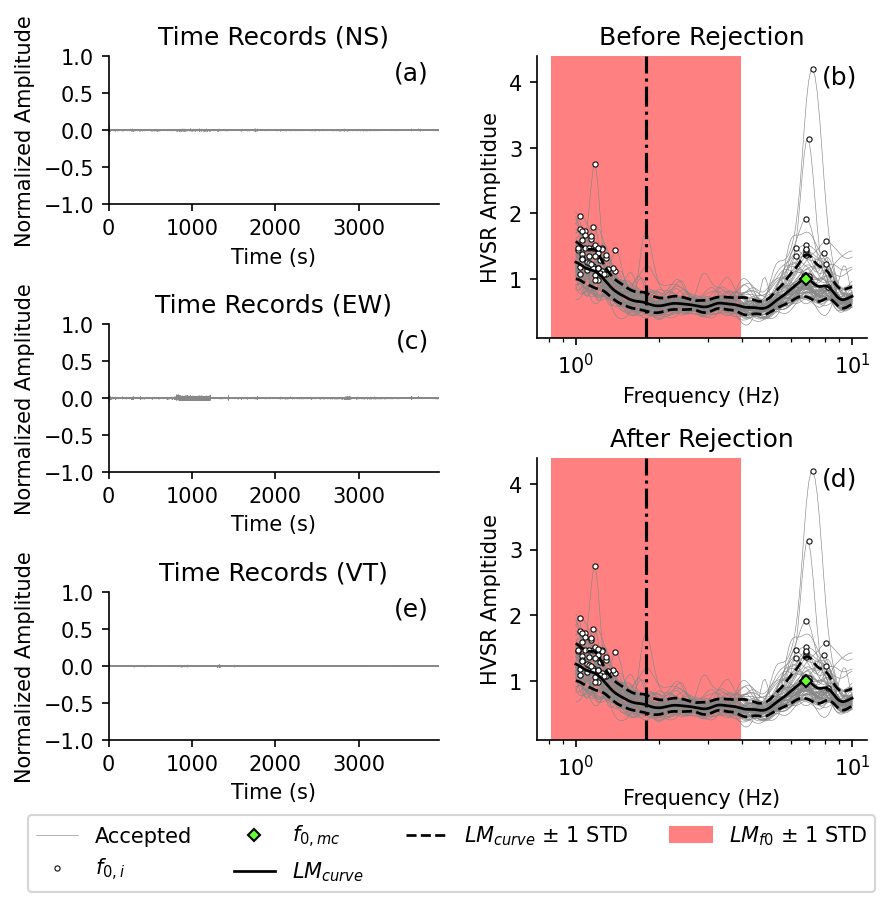

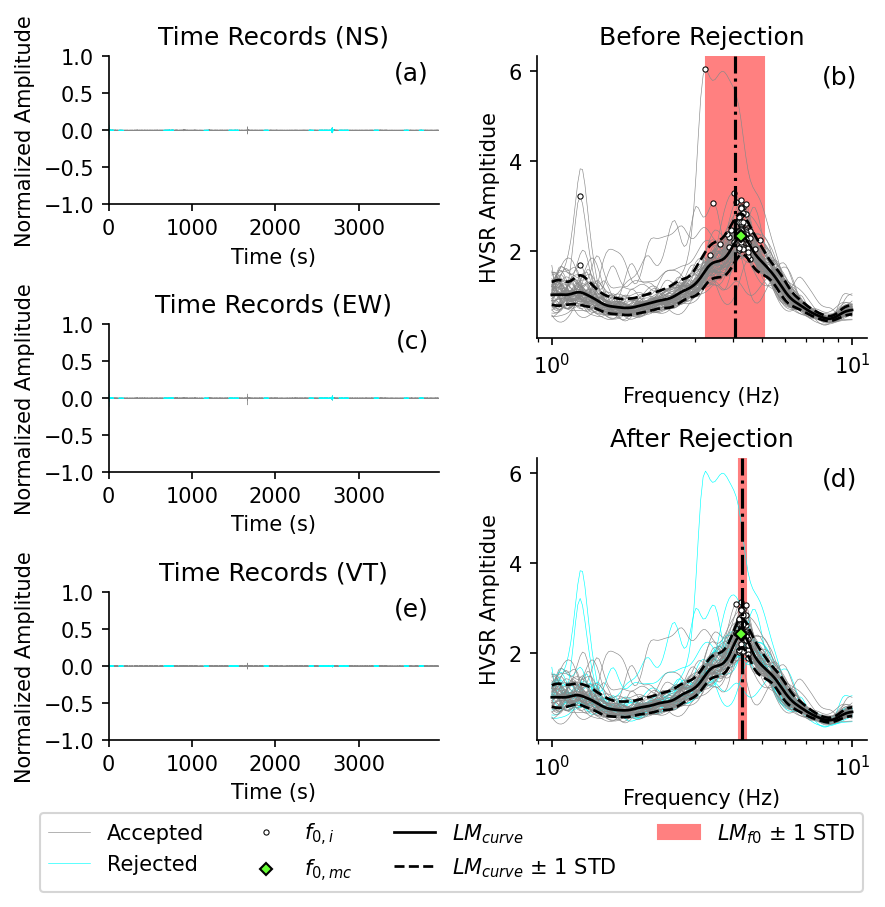

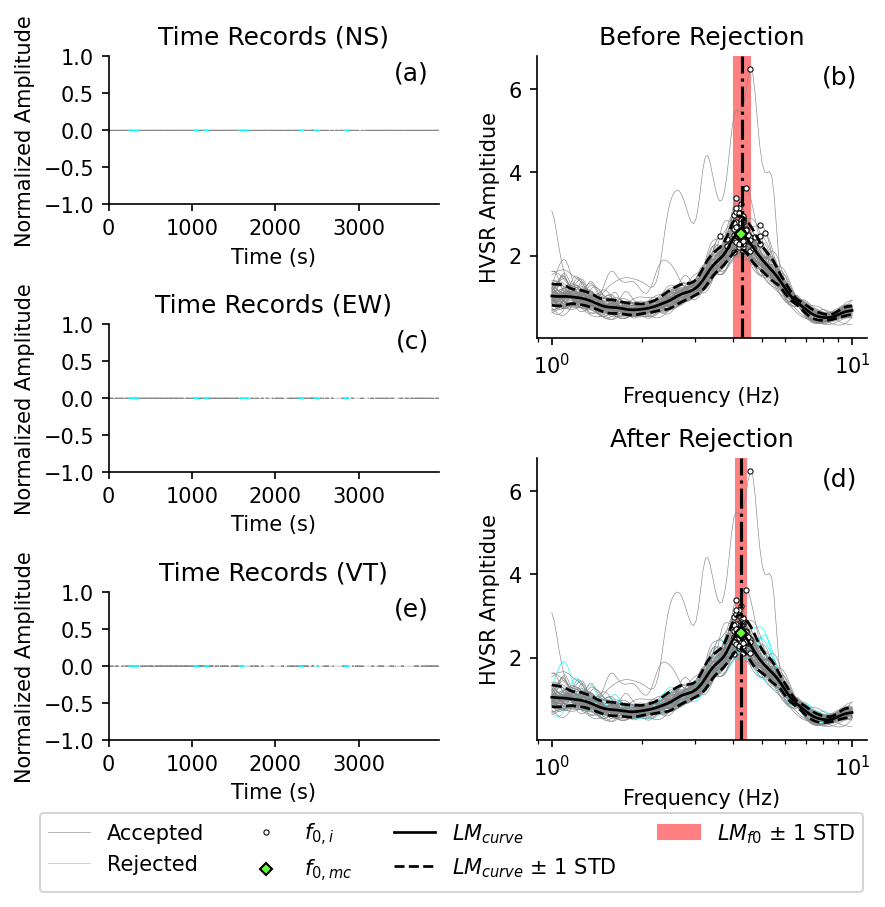

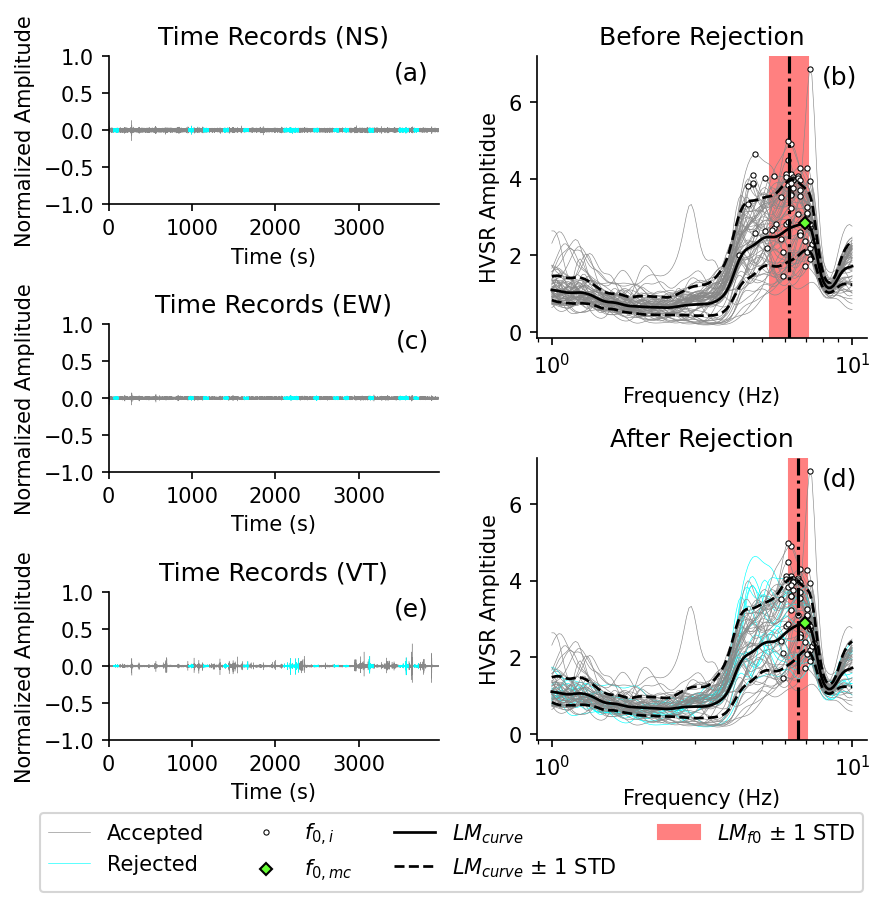

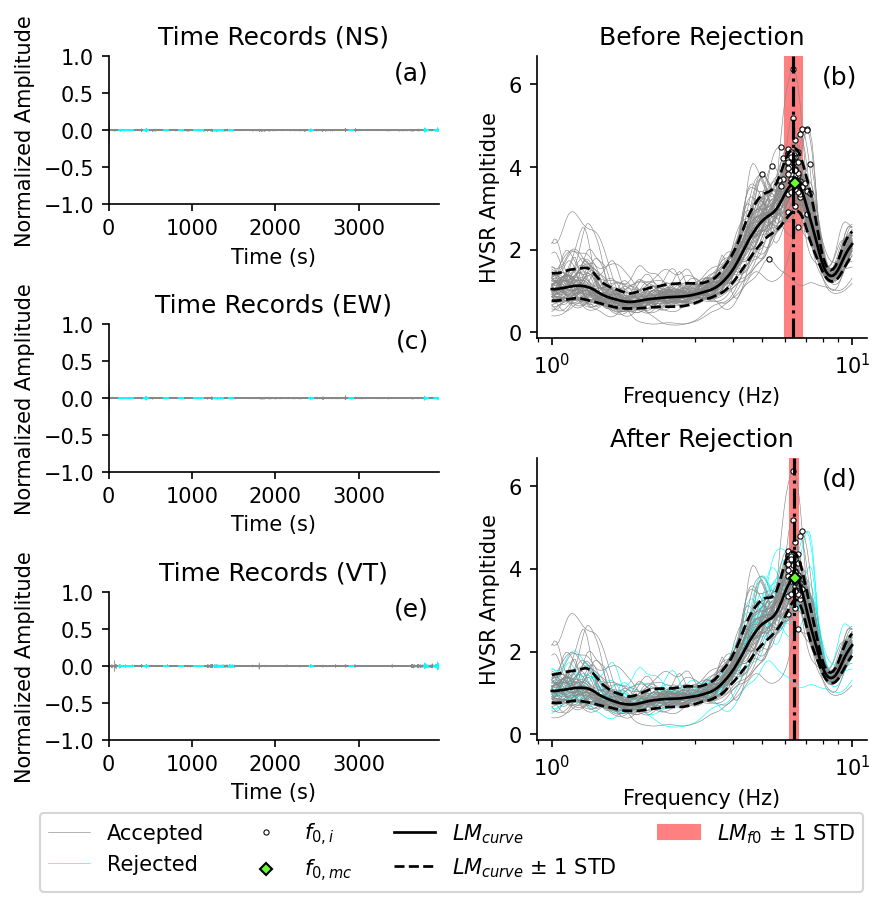

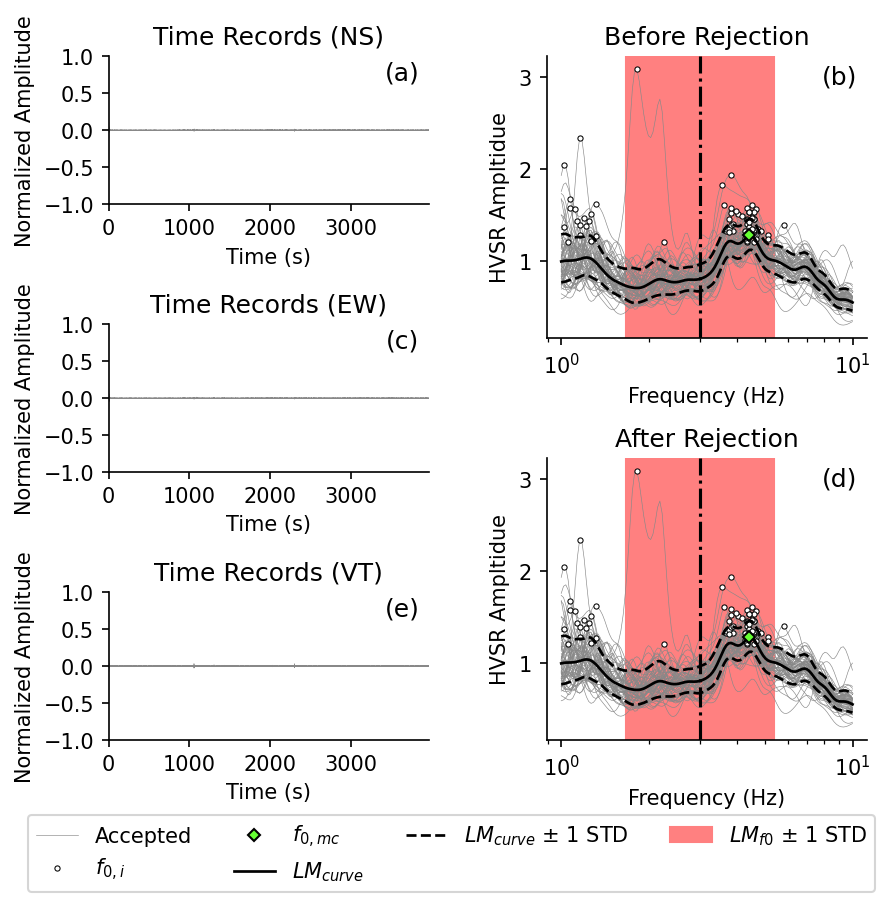

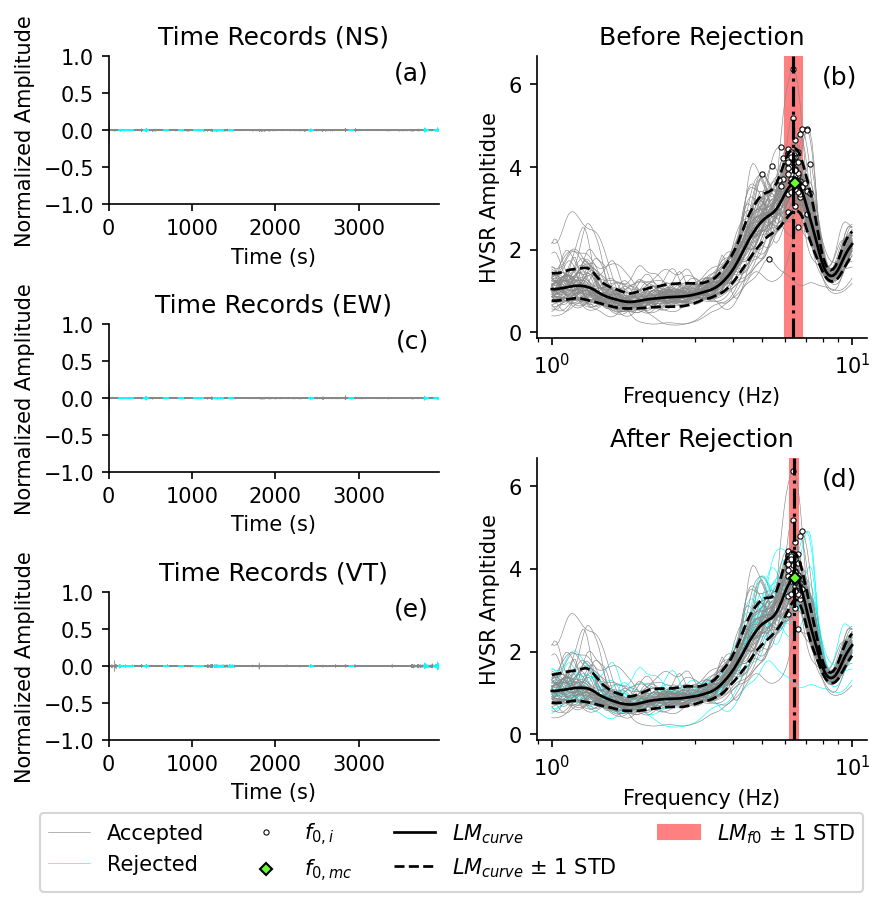

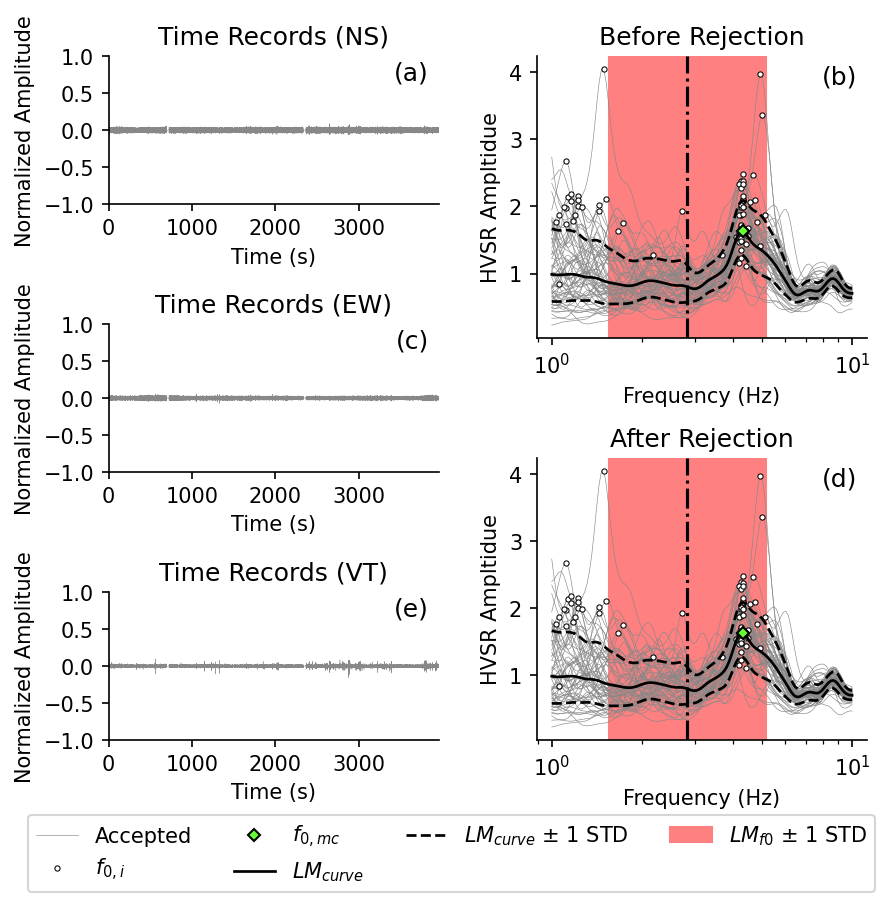

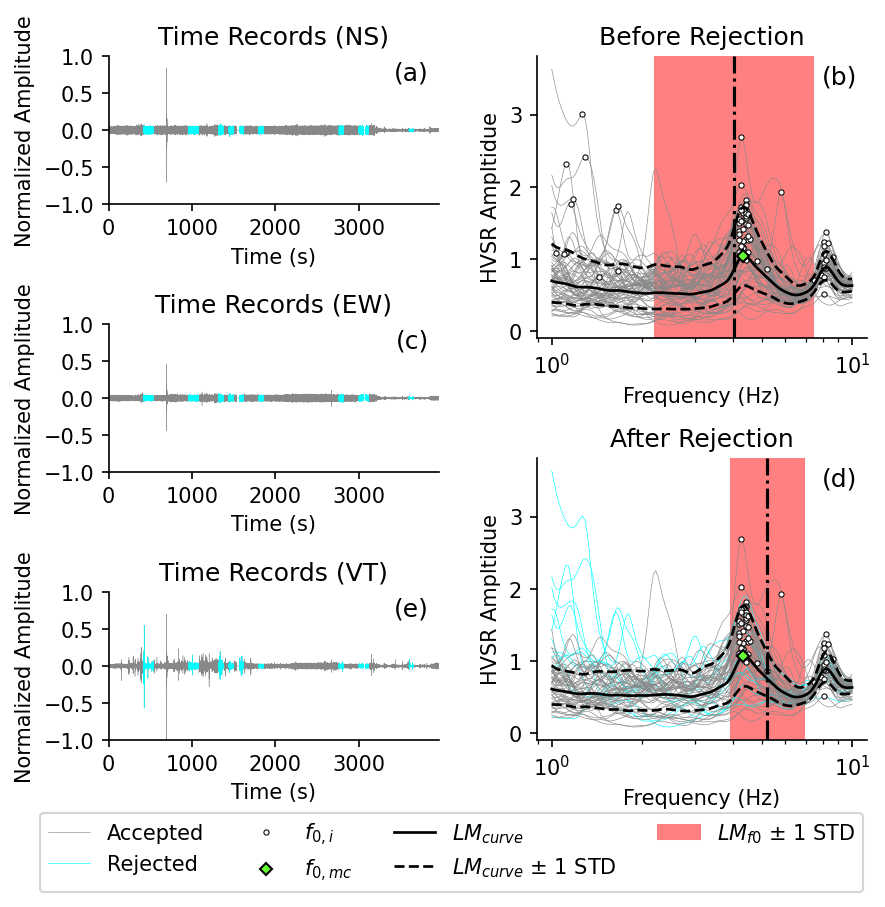

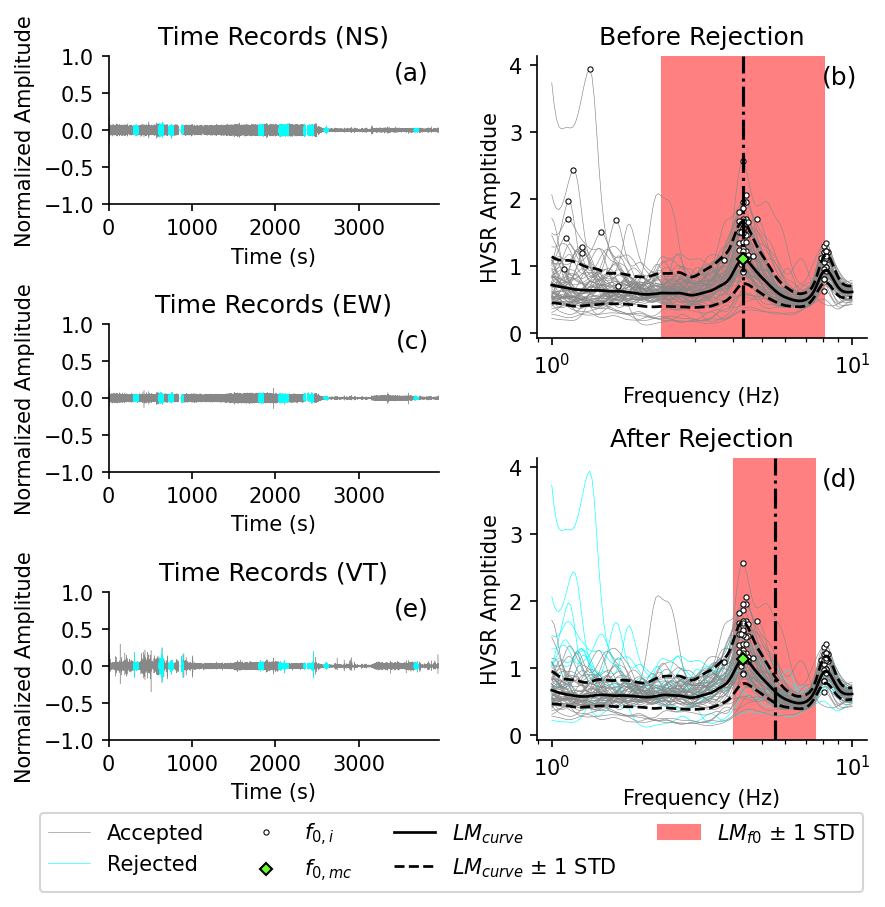

In [112]:
# Input file name from the last step  .

for  i,file_name in enumerate(mseed_list):
    # Window length in seconds. In general low frequency peaks require longer window lengths.
    # See the SESAME guidelines for specific window length recommendations.
    windowlength = 60

    # Boolean to control whether Butterworth filter is applied. 
    # Geopsy does not apply a bandpass filter.
    filter_bool = False        
    # Low-cut frequency for bandpass filter.
    flow = 1                  
    # High-cut frequency for bandpass filter.
    fhigh = 10                  
    # Filter order.
    forder = 5

    # Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    width = 0.1

## Frequency Domain Settings


    # Konno and Ohmachi smoothing constant. 40 is recommended.
    bandwidth = 40

    # Minimum frequency after resampling
    minf = 1  
    # Maximum frequency after resampling
    maxf = 10
    # Number of frequencies after resampling
    nf = 128
    # Type of resampling {'log', 'linear'}
    res_type = 'log'

## H/V Settings


    # Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
    # Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
    method = "geometric-mean"
    # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    azimuth = 0

    # Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
    # Geopsy does not offer this functionality.
    rejection_bool = True
    # Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
    n = 2
    # Maximum number of iterations to perform for rejection -> 50 is recommended.
    n_iteration = 50

    # Distribution of f0 {"log-normal", "normal"}. Geopsy default "normal" -> "log-normal" is recommended.
    distribution_f0 = "log-normal"
    # Distribution of mean curve {"log-normal", "normal"}. Geopsy default "log-normal" -> "log-normal" is recommended.
    distribution_mc = "log-normal"

## Perform Calculation



    fig = plt.figure(figsize=(6,6), dpi=150)
    gs = fig.add_gridspec(nrows=6,ncols=6)

    ax0 = fig.add_subplot(gs[0:2, 0:3])
    ax1 = fig.add_subplot(gs[2:4, 0:3])
    ax2 = fig.add_subplot(gs[4:6, 0:3])

    if rejection_bool:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = fig.add_subplot(gs[3:6, 3:6])
    else:
        ax3 = fig.add_subplot(gs[0:3, 3:6])
        ax4 = False

    start = time.time()
    sensor = hvsrpy.Sensor3c.from_mseed(file_name)
    

    bp_filter = {"flag":filter_bool, "flow":flow, "fhigh":fhigh, "order":forder}
    resampling = {"minf":minf, "maxf":maxf, "nf":nf, "res_type":res_type}
    print('windowlength:',windowlength)
    print('width:',width)
    print('bandwidth:',bandwidth)
    print('resampling:',resampling)
    print('method:',method)
  
    hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, azimuth=azimuth)


    end = time.time()
    print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

    individual_width = 0.3
    median_width = 1.3
    for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
        # Rejected Windows
        if title=="After Rejection":
            if len(hv.rejected_window_indices):
                label = "Rejected"
                for amp in hv.amp[hv.rejected_window_indices]:
                    ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                    label=None

        # Accepted Windows
        label="Accepted"
        for amp in hv.amp[hv.valid_window_indices]:
            ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                    label = label if title=="Before Rejection" else "")
            label=None

        # Window Peaks
        ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
                marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
                label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")

        # Peak Mean Curve
        ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
                marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
                label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")

        # Mean Curve
        label = r"$LM_{curve}$" if distribution_mc=="log-normal" else "Mean"   
        ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
                label="" if title=="Before Rejection" and rejection_bool else label)

        # Mean +/- Curve
        label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="log-normal" else "Mean ± 1 STD"
        ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3,
                label = "" if title=="Before Rejection" and rejection_bool else label)
        ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
                color='k', linestyle='--', linewidth=median_width, zorder=3)

        label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="log-normal" else "Mean f0 ± 1 STD"
        ymin, ymax = ax.get_ylim()
        ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [ymin, ymax], linestyle="-.", color="#000000")
        ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [ymin, ymax, ymax, ymin], 
                color = "#ff8080",
                label="" if title=="Before Rejection" and rejection_bool else label)

        ax.set_ylim((ymin, ymax))
        ax.set_xscale('log')
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("HVSR Ampltidue")
        if rejection_bool:
            if title=="Before Rejection":
                print("\nStatistics before rejection:")
                hv.print_stats(distribution_f0)
                c_iter = hv.reject_windows(n, max_iterations=n_iteration, 
                                           distribution_f0=distribution_f0, distribution_mc=distribution_mc)
            elif title=="After Rejection":
                fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

                print("\nAnalysis summary:")  
                display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                             data=[f"{windowlength}s", str(sensor.ns.n_windows), f"{c_iter} of {n_iteration} allowed", str(len(hv.rejected_window_indices))]))            
                print("\nStatistics after rejection:")
                hv.print_stats(distribution_f0)
                
        else:
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                             data=[f"{windowlength}s", str(sensor.ns.n_windows)]))
            hv.print_stats(distribution_f0)
            fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
            break
        ax.set_title(title)

    norm_factor = sensor.normalization_factor
    for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
        ctime = timerecord.time
        amp = timerecord.amp/norm_factor
        ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
        ax.set_title(f"Time Records ({name})")
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xlim(0, windowlength*timerecord.n_windows)
        ax.set_ylim(-1, 1)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Amplitude')
        for window_index in hv.rejected_window_indices:
            ax.plot(ctime[window_index], amp[window_index], linewidth=0.2, color="cyan")

    if rejection_bool:
        axs = [ax0, ax3, ax1, ax4, ax2]
    else:
        axs = [ax0, ax3, ax1, ax2]

    for ax, letter in zip(axs, list("abcde")):    
        ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
   #
    locs.loc[i,'hvsr_f0']=hv.mc_peak_frq(distribution_mc)
    locs.loc[i,'hvsr_am']=hv.mc_peak_amp(distribution_mc)
   # 
    fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
   # plt.show()
    print("#event:",str(i))
    fig.savefig(file_name+'.png')

In [63]:
locs.to_csv('D:\\blast_blake\\Data_blasts\\hvsr_20hz.csv')

## Plot the hvsr result to the folium map (both the amplitude and F0)
-------------------------------

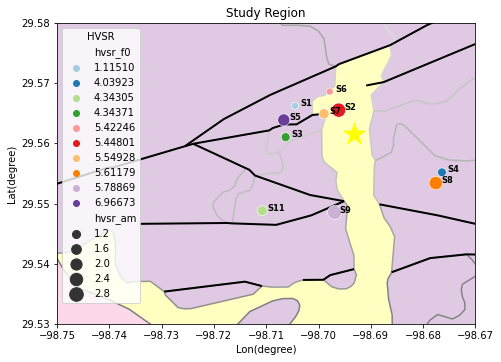

In [64]:
xmin=-98.75;xmax=-98.67;ymin=29.53;ymax=29.58
fig2, ax2 = plt.subplots(1,figsize=(7.5, 6))  

groups = locs.groupby(["name"]).mean()

hvsr=gpd.GeoDataFrame(groups, geometry=gpd.points_from_xy(groups.lon, groups.lat), crs="EPSG:4326")
                                                                  
hvsrplt=sns.scatterplot(ax=ax2,data=hvsr,x="lon", y="lat", size='hvsr_am',hue='hvsr_f0',
                        sizes=(50, 200),zorder=4,
                       hue_norm=(0, 3), palette="Paired",edgecolors='black')
for line in range(0,hvsr.shape[0]):
         hvsrplt.text(hvsr['lon'][line]+0.001, hvsr['lat'][line], 
                 hvsr.index[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold',zorder=5)


gqplt=gqloc.plot(ax=ax2,marker='*', markersize=500,color='yellow',zorder=3,legend=True)
rockplt=geo_p.plot(ax=ax2,column='ROCKTYPE1', cmap='Set1',zorder=1,legend=True,alpha=0.3)
geoplt=geo_arc.plot(ax=ax2,cmap='Greys',zorder=2,legend=False)    
fplt=fault.plot(ax=ax2,color='black',zorder=2,linewidths=2,linestyle='-',legend=True,legend_kwds={'label':"Fault"})


ax2.set_xlabel('Lon(degree)')
ax2.set_ylabel('Lat(degree)')
ax2.set_title('Study Region')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

l = ax2.legend(loc='best',title='HVSR')
l.set_zorder(5) 
for t in l.texts:
    # truncate label text to 4 characters
    t.set_text(t.get_text()[:7])
fig2.savefig('quarry_HVSR.jpg',dpi=200)